# Merge Results

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

from convnwb.paths import Paths
from convnwb.io import get_files, load_jsons_to_df, load_matfile

from spiketools.plts.data import plot_hist
from spiketools.plts.utils import make_axes

In [2]:
import sys
sys.path.append('../code')
from maps import LOC_MAP, SIDE_MAP

In [3]:
import seaborn as sns
sns.set_context('talk', font_scale=0.9)

## Settings

In [4]:
# Set which experiment version to run
stimulus_version = 'face'   # 'face', 'object'

In [5]:
# Define project paths, and create paths object
results_path = Path('../results/units/')
project_path = '/data12/jacobs_lab/WVTH/'
paths = Paths(project_path)

In [6]:
# Define the list of TH versions
TH_VERSIONS = {
    'face' : 'THF',
    'object' : 'THO',
}

In [7]:
# Set significance level
ALPHA_LEVEL = 0.05

In [8]:
# Define a list of analyses
analyses = ['baseline', 'id', 'chest', 'place', 'target', 'serial']

In [9]:
# Get the current version of the TH data
th_experiment = TH_VERSIONS[stimulus_version]

### Treasure Hunt Results

In [10]:
# Get the list of files
res_files = get_files(results_path / th_experiment, select='session')

In [11]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=results_path / th_experiment)

In [12]:
# Check the columns
all_results.columns

Index(['uid', 'session_id', 'subject_id', 'wvID', 'keep', 'n_spikes',
       'firing_rate', 'presence_ratio', 'cluster', 'channel', 'location',
       'fr_t_val_all', 'fr_p_val_all', 'fr_t_val_empt', 'fr_p_val_empt',
       'fr_t_val_full', 'fr_p_val_full', 'place_anova', 'target_anova',
       'serial_anova', 'place_anova_surr_p_val', 'place_anova_surr_z_score',
       'target_anova_surr_p_val', 'target_anova_surr_z_score',
       'serial_anova_surr_p_val', 'serial_anova_surr_z_score'],
      dtype='object')

### Update & add columns for TH related info

In [13]:
# Add binary labels for statistical tests
all_results['is_chest'] = all_results['fr_p_val_full'] < ALPHA_LEVEL
all_results['is_place'] = all_results['place_anova_surr_p_val'] < ALPHA_LEVEL
all_results['is_target'] = all_results['target_anova_surr_p_val'] < ALPHA_LEVEL
all_results['is_serial'] = all_results['serial_anova_surr_p_val'] < ALPHA_LEVEL

### Update Region Information

In [14]:
# Set and collect which area each unit it is
all_results['region'] = all_results['location'].map(LOC_MAP)
all_results['side'] = all_results['location'].map(SIDE_MAP)

## Load 1-back Data Files

### FILE 1: Unit Labels

The first file contains information on the labels that each unit received from analyses in the 1-back task.

Identity neuron fields:
- ID_neuron: identity neuron
- MI_neuron: multiple identity neuron
- SI_neuron: single identity neuron

In [15]:
# Define the file path for the relevant nback results file
if stimulus_version == 'face':
    id_file_name = 'ID neuron CelebA_NavSelect MeanResponse 2SD.mat'
if stimulus_version == 'object':
    id_file_name = 'ID neuron ImageNet_NavSelect MeanResponse 2SD.mat'

In [16]:
# Load nback results data
nback_data = load_matfile(id_file_name, folder=paths.info / 'nback', squeeze_me=True)

In [17]:
# Check the available keys in the loaded nback data
keys = [key for key in nback_data.keys() if key[0] != '_']
keys

['CodeID', 'CodeIDNum', 'ID_neuron', 'MI_neuron', 'SI_neuron', 'selMethod']

In [18]:
# Define a list of variables we can drop
drop_vars = ['CodeID', 'selMethod', 'CodeIDNum']

# Get a list of underscore variables that we can drop
f_dunders = [key for key in nback_data.keys() if key[0] == '_']

In [19]:
# Drop some data that we are not using here
for field in [*drop_vars, *f_dunders]:
    nback_data.pop(field, None)

### FILE 2

Words, words, words.

In [20]:
# Define the file path for the relevant nback results file
if stimulus_version == 'face':
    file_name = 'SortedFRCelebA_Nav.mat'
if stimulus_version == 'object':
    file_name = 'SortedFRImageNet_Nav.mat'

In [21]:
# Load the data file
fr_data = load_matfile(file_name, folder=paths.info / 'nback', squeeze_me=True)

In [22]:
# Check the available keys in the metadata file
print([el for el in fr_data.keys() if el[0] != '_'])

['sessions', 'timestampsOfCellAll', 'vCell', 'areaCell', 'vCh', 'vClusterID', 'vWire', 'periodsAll', 'binW', 'binStep', 'FR', 'beh', 'FR_sort', 'vReject', 'vKeep', 'pBase', 'pAnova', 'vAnova', 'vBase']


In [23]:
# Add the baseline response firing analysis to collection of analyses
nback_data['vBase'] = fr_data['vBase']

In [24]:
# Check the collected n-back label data
nback_data

{'ID_neuron': array([ 11,  67,  75, 158, 159, 208, 223, 281, 401, 420, 505, 537, 598,
        628, 630, 787,  24,  44,  49,  60,  64,  69,  77,  95, 102, 156,
        162, 261, 266, 268, 274, 283, 293, 373, 494, 525, 545, 602, 614,
        620, 681, 682, 694, 725, 734, 748, 750, 772, 791, 814, 840, 842,
        902], dtype=uint16),
 'MI_neuron': array([ 24,  44,  49,  60,  64,  69,  77,  95, 102, 156, 162, 261, 266,
        268, 274, 283, 293, 373, 494, 525, 545, 602, 614, 620, 681, 682,
        694, 725, 734, 748, 750, 772, 791, 814, 840, 842, 902],
       dtype=uint16),
 'SI_neuron': array([ 11,  67,  75, 158, 159, 208, 223, 281, 401, 420, 505, 537, 598,
        628, 630, 787], dtype=uint16),
 'vBase': array([  4,  24,  26,  48,  54,  64,  65,  67,  69,  70,  81,  85,  96,
         98, 100, 103, 107, 122, 129, 140, 152, 156, 158, 159, 162, 164,
        168, 169, 170, 171, 177, 181, 191, 217, 221, 241, 250, 252, 253,
        264, 266, 286, 289, 298, 305, 308, 325, 353, 355, 357, 381, 

### FILE 3

In [25]:
# Define the file path for the relevant nback results file
if stimulus_version == 'face':
    stats_filename = 'vID_vBase_Selection_CelebA_Nav.csv'
if stimulus_version == 'object':
    stats_filename = 'vID_vBase_Selection_ImageNet_Nav.csv'

In [26]:
# Load n-back stats
nback_stats = pd.read_csv(paths.info / 'nback' / stats_filename)

In [27]:
# Rename the columns
new_names = {'CellIndex' : 'wvID',
             'Fvalue-anova' : 'id_fvalue',
             'TValue-baseline' : 'baseline_tvalue', 
             'IDNeuron' : 'is_id', 
             'vBaseline' : 'is_baseline'}
nback_stats.rename(columns=new_names, inplace=True)

In [28]:
# Sub-select only stats columns
nback_stats = nback_stats[['wvID', 'id_fvalue', 'baseline_tvalue', 'is_id', 'is_baseline']]

In [29]:
# Check that the information from different n-back files is consistent
assert set(nback_stats[nback_stats['is_id'] == 1].wvID.values) == set(nback_data['ID_neuron'])
assert set(nback_stats[nback_stats['is_baseline'] == 1].wvID.values) == set(nback_data['vBase'])

In [30]:
# Set type of indicator columns to bool
nback_stats['is_id'] = nback_stats['is_id'].astype(bool)
nback_stats['is_baseline'] = nback_stats['is_baseline'].astype(bool)

## Merge Data

In [31]:
# Create merged df
all_results = all_results.merge(nback_stats)

In [32]:
# Add single & multi ID labels to DF
all_results['id_type'] = None
for sid in nback_data['SI_neuron']:
    all_results.loc[all_results['wvID'] == sid, 'id_type'] = 'single'
for mid in nback_data['MI_neuron']:
    all_results.loc[all_results['wvID'] == mid, 'id_type'] = 'multi'

# Check this worked
assert set(all_results[all_results.id_type == 'single'].wvID) == set(nback_data['SI_neuron'])
assert set(all_results[all_results.id_type == 'multi'].wvID) == set(nback_data['MI_neuron'])

In [33]:
# Create absolute value'd version of t-distributions
all_results['baseline_tvalue_abs'] = np.abs(all_results['baseline_tvalue'])
all_results['fr_t_val_full_abs'] = np.abs(all_results['fr_t_val_full'])

## Check Unit Quality Measures

In [34]:
# Firing rate threshold checks
print('# neurons fr < 0.15: \t', sum(all_results.firing_rate < 0.15))
#print('# neurons fr < 0.50: \t', sum(all_results.firing_rate < 0.50))

# neurons fr < 0.15: 	 35


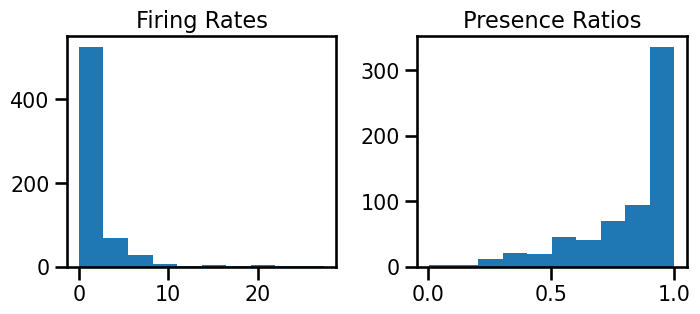

In [35]:
# Plot distribution of unit measures
axes = make_axes(2, 2, figsize=(8, 3), wspace=0.3)
plot_hist(all_results['firing_rate'].values, title='Firing Rates', ax=axes[0])
plot_hist(all_results['presence_ratio'].values, title='Presence Ratios', ax=axes[1])

In [36]:
# Check similarity of low firing rate & low presence ratio
low_frs = (all_results['firing_rate'] < 0.15).values
low_prs = (all_results['presence_ratio'] < 0.4).values
low_both = np.logical_and(low_frs, low_prs)

In [37]:
# Check the numbers of units for each measure
print('# low fr: \t{}'.format(sum(low_frs)))
print('# low pr: \t{}'.format(sum(low_prs)))
print('# low both: \t{}'.format(sum(low_both)))

# low fr: 	35
# low pr: 	38
# low both: 	31


In [38]:
# Add a marker for firing rate threshold in the TH experiment
all_results['keep_th'] = (all_results['firing_rate'] > 0.15).values

### Dropped Neurons

In [39]:
# Extract dropped neurons
dropped = all_results[~all_results['keep_th']]

In [40]:
# Check number of dropped neurons
n_dropped = len(dropped)
print('# of dropped units: \t{}'.format(n_dropped))

# of dropped units: 	35


In [41]:
# Check dropped neurons
print(stimulus_version + ' - dropped:')
for analysis in analyses:
    temp = dropped[dropped['is_' + analysis]]
    print('\t{} ({} sig dropped): '.format(analysis, len(temp)))
    for _, row in temp.iterrows():
        print('\t\t' + row.session_id + '_U' + str(row.uid) + '  wvID:' + str(row.wvID))

face - dropped:
	baseline (4 sig dropped): 
		THF_wv001_session_3_U9  wvID:191
		THF_wv001_session_4_U55  wvID:357
		THF_wv004_session_0_U31  wvID:625
		THF_wv004_session_1_U8  wvID:744
	id (2 sig dropped): 
		THF_wv001_session_0_U76  wvID:77
		THF_wv002_session_1_U41  wvID:537
	chest (0 sig dropped): 
	place (6 sig dropped): 
		THF_wv001_session_3_U9  wvID:191
		THF_wv001_session_3_U60  wvID:242
		THF_wv001_session_3_U67  wvID:249
		THF_wv001_session_4_U55  wvID:357
		THF_wv002_session_1_U63  wvID:559
		THF_wv004_session_1_U23  wvID:759
	target (0 sig dropped): 
	serial (4 sig dropped): 
		THF_wv001_session_3_U60  wvID:242
		THF_wv001_session_4_U55  wvID:357
		THF_wv004_session_1_U8  wvID:744
		THF_wv004_session_1_U72  wvID:808


In [42]:
# Sub-select main results file to keep neurons
all_results = all_results[all_results['keep_th']]

In [43]:
# Check number of neurons
n_units = len(all_results)
print('# neurons: ', n_units)

# neurons:  608


## Save Out Results

In [44]:
# Save out of CSV
results_fname = 'all_results-' + stimulus_version + '.csv'
all_results.to_csv(results_path / 'all' / results_fname , index=False)